In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path

import jaxtyping

In [6]:
import sys
# Make sure exercises are in the path
exercises_dir = Path("../scripts").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from model import Tree, Config, Model, construct_tree

from plotly_utils import imshow, line, hist
from utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
    plot_features_in_2d_hierarchy_labeled
)
# import part4_superposition_and_saes.tests as tests
# import part4_superposition_and_saes.solutions as solutions

if t.backends.mps.is_available():
    print("current PyTorch install was "
              "built with MPS enabled.")
    if t.backends.mps.is_built():
        print("MPS is available")
        device = t.device("mps")
else:
    device = t.device("cuda" if t.cuda.is_available() else "cpu")

current PyTorch install was built with MPS enabled.
MPS is available


# Create a Large Tree, of Depth 9, Branching Factor 2

In [8]:
tree = construct_tree(branching_factor = 2, depth = 9)
len(tree.to_list())
# Create Class to Store Tree

1022

## Try model dimension of 2

In [31]:
cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 2,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model = Model(
    cfg = cfg,
    device = device,
)
model.optimize(steps=10000)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

  0%|          | 0/10000 [00:00<?, ?it/s]

In [40]:
batch_data = model.generate_batch(1)


tensor([[[1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='mps:0')


In [46]:
model_output_data =model(batch_data)

In [42]:
# plot the first instance as a bar chart for batch_data and model(batch_data)
import matplotlib.pyplot as plt

# Plot the first instance of batch_data
import plotly.graph_objects as go

def plot_batch_data(batch_data, model_output_data, tree, i):    # Get the list of tree paths
    tree_paths = tree.to_list()
    fig = go.Figure(data=[
        go.Scatter(
            x=tree_paths,
            y=batch_data[0, i].cpu().numpy(),
            mode='lines',
            name='Batch Data',
            hovertemplate='%{x}<br>%{y}'
        ),
        go.Scatter(
            x=tree_paths,
            y=model_output_data[0, i].detach().cpu().numpy(),
            mode='lines',
            name='Model Output',
            hovertemplate='%{x}<br>%{y}'
        )
    ])

    fig.update_layout(
        title='First Instance of Batch Data and Model Output',
        yaxis_title='Value',
        width=1200,
        height=600,
        legend_title='Data Source',
        xaxis=dict(
            showticklabels=False,
            title=None,
            hoverformat='%{x}'
        )
    )

    fig.show()

In [59]:
plot_batch_data(batch_data, model_output_data, tree, 3)

## Try Model Dimension of 5

In [57]:
cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 5,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model_5 = Model(
    cfg = cfg,
    device = device,
)
model_5.optimize(steps=10000)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

  0%|          | 0/10000 [00:00<?, ?it/s]

In [60]:
batch_data = model_5.generate_batch(1)
model_output_data = model_5(batch_data)

plot_batch_data(batch_data, model_output_data, tree, 0)


In [61]:
## Try Model Dimension of 6
cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 6,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model_6 = Model(
    cfg = cfg,
    device = device,
)
model_6.optimize(steps=10000)



  0%|          | 0/10000 [00:00<?, ?it/s]

In [62]:
batch_data = model_6.generate_batch(1)
model_output_data = model_6(batch_data)

plot_batch_data(batch_data, model_output_data, tree, 0)


## Try Model Dimension of 7

In [63]:
## Try Model Dimension of 6
cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 7,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model_7 = Model(
    cfg = cfg,
    device = device,
)
model_7.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [68]:
batch_data = model_7.generate_batch(1)
model_output_data = model_7(batch_data)
plot_batch_data(batch_data, model_output_data, tree, 4)


## Try Model Dimension of 1

In [69]:

## Try Model Dimension of 8
cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 1,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model_1 = Model(
    cfg = cfg,
    device = device,
)
model_1.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [72]:
batch_data = model_1.generate_batch(1)
model_output_data = model_1(batch_data)
plot_batch_data(batch_data, model_output_data, tree, 2)


In [93]:
batch_data, indices = model_1.generate_batch(1000, return_indices = True)
batch_data_W = einops.einsum(batch_data, model_1.W, "batch n_instance n_features, n_instance n_hidden n_features -> batch n_instance n_hidden")


In [100]:
# Plot batch_data_W for instance 0 as a 1D number line with tree index labels
import plotly.graph_objects as go
import numpy as np

i = 0
# Extract data for instance 0
instance_0_data = batch_data_W[:, i, 0].detach().cpu().numpy()
instance_0_indices = [tree.to_list()[i.item()] for i in indices[:, i]]

# Define color mapping for the four buckets and edge cases
color_map = {
    '0.0': 'blue',
    '0.1': 'green',
    '1.0': 'red',
    '1.1': 'purple',
    '0': 'orange',
    '1': 'yellow'
}

# Assign colors based on the label prefix
def get_color(label):
    if label in ['0', '1']:
        return color_map[label]
    return color_map.get(label[:3], 'gray')  # Use 'gray' for any unmatched prefixes

colors = [get_color(label) for label in instance_0_indices]

# Create the 1D number line plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=instance_0_data,
    y=np.zeros_like(instance_0_data),
    mode='markers+text',
    marker=dict(
        size=10,
        color=colors,
        showscale=False
    ),
    text=[f"{idx}" for idx in range(len(instance_0_data))],
    textposition="top center",
    hovertext=[f"Index: {idx}<br>Label: {label}<br>Value: {value:.4f}" 
               for idx, (label, value) in enumerate(zip(instance_0_indices, instance_0_data))],
    hoverinfo='text'
))

fig.update_layout(
    title="batch_data_W for Instance 0 (1D Number Line)",
    xaxis_title="Value",
    yaxis_title="",
    yaxis_showticklabels=False,
    height=600,
    width=1000
)

# Add a legend for the color buckets
for prefix, color in color_map.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        showlegend=True,
        name=f'Prefix: {prefix}'
    ))

# Add legend entry for unmatched prefixes
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=10, color='gray'),
    showlegend=True,
    name='Other prefixes'
))

fig.show()

## Try Model dimension of 8

In [101]:

## Try Model Dimension of 8
cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 8,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model_8 = Model(
    cfg = cfg,
    device = device,
)
model_8.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [105]:
batch_data = model_8.generate_batch(1)
model_output_data = model_8(batch_data)
plot_batch_data(batch_data, model_output_data, tree, 0)


## Try Model Dimension of 9

In [9]:
cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 9,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model_9 = Model(
    cfg = cfg,
    device = device,
)
model_9.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [54]:
batch_data = model_9.generate_batch(1)
batch_data.sum(dim=-1)


tensor([[5., 8., 9., 9., 5., 9.]], device='mps:0')

In [70]:
batch_data = model_9.generate_batch(1)
model_output_data = model_9(batch_data)
plot_batch_data(batch_data, model_output_data, tree, 0)


## Try Model Dimension of 12


In [74]:
cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 12,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model_12 = Model(
    cfg = cfg,
    device = device,
)
model_12.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [79]:
batch_data = model_12.generate_batch(1)
model_output_data = model_12(batch_data)
plot_batch_data(batch_data, model_output_data, tree, 0)


## Try Model Dimension of 20

In [98]:
## Try Model Dimension of 20

cfg = Config(
    n_instances = 6,
    tree = tree,
    n_hidden = 20,
    partial_paths = True,
    n_features = len(tree.to_list())
)

model_20 = Model(
    cfg = cfg,
    device = device,
)
model_20.optimize(steps=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [106]:

batch_data = model_20.generate_batch(1)
model_output_data = model_20(batch_data)
plot_batch_data(batch_data, model_output_data, tree, 0)


## Get Cosine Similarity of Two Features

In [107]:
def get_index_from_path(path, tree):
    node_list = tree.to_list()
    return node_list.index(path)

def get_cosine_similarity(path1, path2, model):
    index1 = get_index_from_path(path1, model.cfg.tree)
    index2 = get_index_from_path(path2, model.cfg.tree)
    W = model.W.detach().cpu()
    return cos(W[:,:,index1], W[:,:,index2])


In [109]:
depth = 9

cosine_similarities = {}
for i in cfg.tree.to_list():
    # if i has children, get cosine similarity of i and its children
    current_depth = i.count(".") + 1
    if current_depth < depth:
        cosine_similarities[(i, i + ".0")] = {
            "similarity": get_cosine_similarity(i, i + ".0", model_20).mean().item(),
            "depth": current_depth
        }
        cosine_similarities[(i, i + ".1")] = {
            "similarity": get_cosine_similarity(i, i + ".1", model_20).mean().item(),
            "depth": current_depth
        }


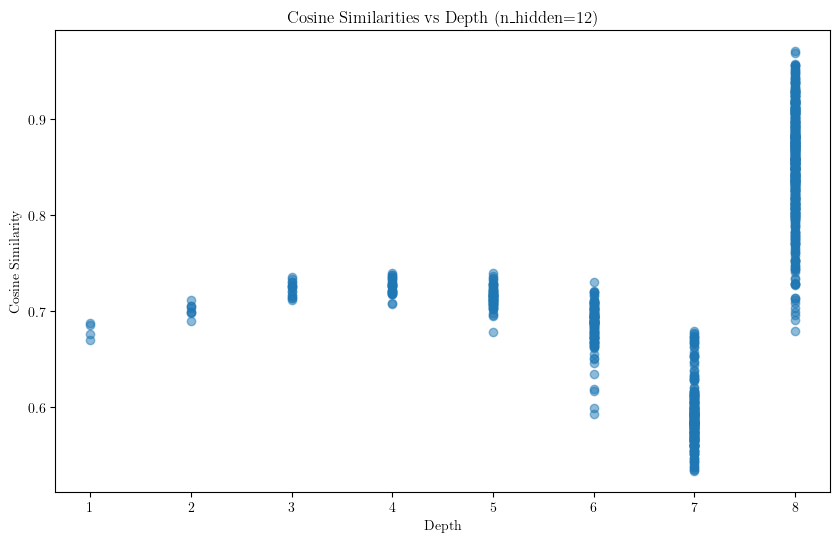

In [112]:
depth = 9
model_plot = model_12

cosine_similarities = {}
for i in cfg.tree.to_list():
    # if i has children, get cosine similarity of i and its children
    current_depth = i.count(".") + 1
    if current_depth < depth:
        cosine_similarities[(i, i + ".0")] = {
            "similarity": get_cosine_similarity(i, i + ".0", model_plot).mean().item(),
            "depth": current_depth
        }
        cosine_similarities[(i, i + ".1")] = {
            "similarity": get_cosine_similarity(i, i + ".1", model_plot).mean().item(),
            "depth": current_depth
        }


## plot cosine_similarities as a histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
similarities = [data['similarity'] for data in cosine_similarities.values()]
depths = [data['depth'] for data in cosine_similarities.values()]
plt.scatter(depths, similarities, alpha=0.5)
plt.title(f"Cosine Similarities vs Depth (n_hidden={model_plot.cfg.n_hidden})")
plt.xlabel("Depth")
plt.ylabel("Cosine Similarity")
# plt.colorbar(label="Depth")
plt.show()

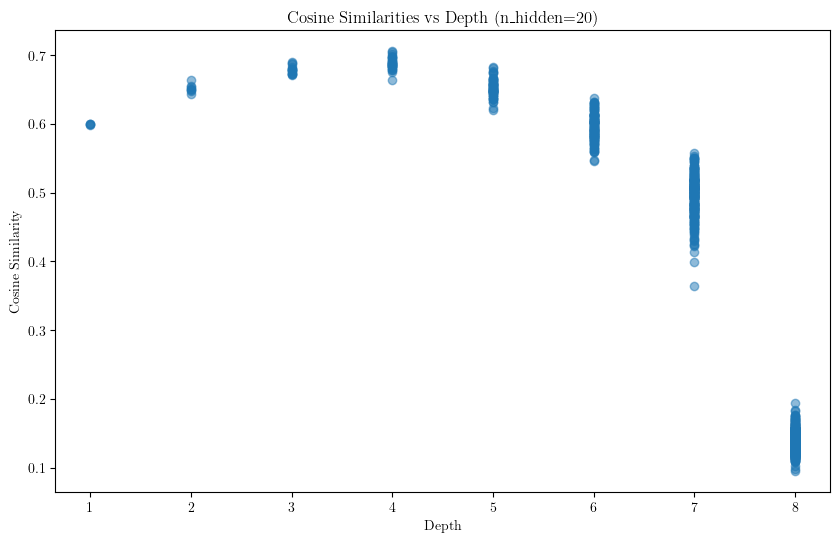

In [111]:
## plot cosine_similarities as a histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
similarities = [data['similarity'] for data in cosine_similarities.values()]
depths = [data['depth'] for data in cosine_similarities.values()]
plt.scatter(depths, similarities, alpha=0.5)
plt.title(f"Cosine Similarities vs Depth (n_hidden={model_20.cfg.n_hidden})")
plt.xlabel("Depth")
plt.ylabel("Cosine Similarity")
# plt.colorbar(label="Depth")
plt.show()


